# Лабаораторная работа №2: Классификация аудио

In [1]:
%pip -q install datasets torchaudio torch torchvision scikit-learn transformers accelerate numpy matplotlib tqdm torchcodec --upgrade

import numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchaudio.transforms as T
from datasets import load_dataset, Audio
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report
from tqdm import tqdm
from transformers import AutoProcessor, AutoModelForAudioClassification, TrainingArguments, Trainer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
SR = 16000



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Device: cuda


In [2]:
ds = load_dataset("danavery/urbansound8K")
ds = ds.cast_column("audio", Audio(sampling_rate=SR))

def by_fold(d, folds): return d.filter(lambda ex: ex["fold"] in folds)
train_raw = by_fold(ds["train"], list(range(1,9)))   # 1..8
valid_raw = by_fold(ds["train"], [9])                # 9
test_raw  = by_fold(ds["train"], [10])               # 10

labels = sorted(list(set(train_raw["class"])))
label2id = {l:i for i,l in enumerate(labels)}
id2label = {i:l for l,i in label2id.items()}
label_col = "class"

len(train_raw), len(valid_raw), len(test_raw), len(labels)


Filter:   0%|          | 0/8732 [00:00<?, ? examples/s]

Filter:   0%|          | 0/8732 [00:00<?, ? examples/s]

Filter:   0%|          | 0/8732 [00:00<?, ? examples/s]

(7079, 816, 837, 10)

In [3]:
N_MELS, N_FFT, HOP = 64, 1024, 256
FMIN, FMAX = 20.0, SR/2
mel = T.MelSpectrogram(sample_rate=SR, n_fft=N_FFT, hop_length=HOP,
                       n_mels=N_MELS, f_min=FMIN, f_max=FMAX, power=2.0)
to_db = T.AmplitudeToDB(top_db=80)

def logmel_stats(ex):
    wav = torch.tensor(ex["audio"]["array"], dtype=torch.float32).unsqueeze(0)
    with torch.no_grad():
        S = to_db(mel(wav)).squeeze(0).numpy().astype("float32")  # (M,T)
    m, s = S.mean(), S.std() + 1e-6
    S = (S - m) / s
    feat = np.concatenate([S.mean(1), S.std(1)]).astype("float32")
    return {"feat": feat, "y": label2id[ex[label_col]]}

def to_xy(split):
    a = split.map(logmel_stats, remove_columns=split.column_names)
    return np.stack(a["feat"]), np.array(a["y"])

X_tr, y_tr = to_xy(train_raw)
X_va, y_va = to_xy(valid_raw)
X_te, y_te = to_xy(test_raw)

clf = Pipeline([("scaler", StandardScaler()), ("svm", LinearSVC())])
clf.fit(X_tr, y_tr)
print("LinearSVC  VAL acc:", accuracy_score(y_va, clf.predict(X_va)))
print("LinearSVC  TEST acc:", accuracy_score(y_te, clf.predict(X_te)))


Map:   0%|          | 0/7079 [00:00<?, ? examples/s]

Map:   0%|          | 0/816 [00:00<?, ? examples/s]

Map:   0%|          | 0/837 [00:00<?, ? examples/s]

LinearSVC  VAL acc: 0.5551470588235294
LinearSVC  TEST acc: 0.5077658303464755


In [ ]:
class RawWaveDS(Dataset):
    def __init__(self, split): self.s = split
    def __len__(self): return len(self.s)
    def __getitem__(self, i):
        ex = self.s[i]
        return torch.tensor(ex["audio"]["array"], dtype=torch.float32), label2id[ex[label_col]]

def pad_collate(batch):
    waves, ys = zip(*batch)
    L = max(w.shape[0] for w in waves)
    X = torch.zeros(len(waves), L)
    for i,w in enumerate(waves): 
        X[i,:w.shape[0]] = w
    return X, torch.tensor(ys, dtype=torch.long)

train_loader = DataLoader(RawWaveDS(train_raw), batch_size=32, shuffle=True,  num_workers=0, collate_fn=pad_collate)
val_loader   = DataLoader(RawWaveDS(valid_raw), batch_size=32, shuffle=False, num_workers=0, collate_fn=pad_collate)
test_loader  = DataLoader(RawWaveDS(test_raw),  batch_size=32, shuffle=False, num_workers=0, collate_fn=pad_collate)

mel_gpu = T.MelSpectrogram(sample_rate=SR, n_fft=N_FFT, hop_length=HOP,
                           n_mels=N_MELS, f_min=FMIN, f_max=FMAX, power=2.0).to(device)
to_db_gpu = T.AmplitudeToDB(top_db=80).to(device)
FIX_T = 128
def to_logmel_batch(xb_1d):
    S = to_db_gpu(mel_gpu(xb_1d))          # (B,M,Tm)
    m = S.mean(dim=(1,2), keepdim=True); s = S.std(dim=(1,2), keepdim=True).clamp_min(1e-6)
    S = (S - m)/s
    Tm = S.size(-1)
    if Tm < FIX_T: 
        S = F.pad(S, (0, FIX_T-Tm))
    else: 
        S = S[:, :, :FIX_T]
    return S.unsqueeze(1)                  # (B,1,M,FIX_T)

class VGGishAudio(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.f = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.h = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        return self.h(self.f(x))


model = VGGishAudio(len(label2id)).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)
crit = nn.CrossEntropyLoss()

from sklearn.metrics import f1_score

def run_epoch(loader, train=True, tag=""):
    model.train() if train else model.eval()
    loss_sum, correct, total = 0.0, 0, 0

    all_y_true = []
    all_y_pred = []

    for xb_wave, yb in tqdm(loader, desc=tag, leave=False):
        xb_wave, yb = xb_wave.to(device), yb.to(device)
        xb = to_logmel_batch(xb_wave)
        if train:
            opt.zero_grad(set_to_none=True)

        with torch.set_grad_enabled(train):
            logits = model(xb)
            loss = crit(logits, yb)
            if train:
                loss.backward()
                opt.step()

        # base metrics
        loss_sum += loss.item() * xb.size(0)
        pred = logits.argmax(1)
        correct += (pred == yb).sum().item()
        total += xb.size(0)

    acc = correct / total
    loss_avg = loss_sum / total


    return loss_avg, acc


# ---- history для графиков ----
history = {
    "tr_loss": [],
    "tr_acc":  [],
    "va_loss": [],
    "va_acc":  [],
}

epochs = 3
for ep in range(1, epochs + 1):
    tr_l, tr_a = run_epoch(train_loader, True,  f"train {ep}/{epochs}")
    va_l, va_a = run_epoch(val_loader,   False, f"valid {ep}/{epochs}")
    
    history["tr_loss"].append(tr_l)
    history["tr_acc"].append(tr_a)
    history["va_loss"].append(va_l)
    history["va_acc"].append(va_a)
    

    print(f"Ep {ep:02d}: train {tr_l:.4f}/{tr_a:.3f} | valid {va_l:.4f}/{va_a:.3f}")

# Тест
model.eval(); y_true, y_pred = [], []
with torch.no_grad():
    for xb_wave, yb in tqdm(test_loader, desc="test", leave=False):
        logits = model(to_logmel_batch(xb_wave.to(device)))
        y_true += yb.numpy().tolist()
        y_pred += logits.argmax(1).cpu().numpy().tolist()

print("CNN TEST acc:", accuracy_score(y_true, y_pred))
print(history)

train 1/3:   0%|          | 0/222 [00:00<?, ?it/s]

Ep 01: train 1.4350/0.488 | valid 1.2756/0.556


Ep 02: train 0.9374/0.680 | valid 1.8437/0.558


Ep 03: train 0.7849/0.739 | valid 0.9851/0.711


CNN TEST acc: 0.6965352449223416
{'tr_loss': [1.4349843058348342, 0.9374058023568752, 0.7849464121806553], 'tr_acc': [0.4884870744455432, 0.6803220793897443, 0.7386636530583416], 'va_loss': [1.275593908686264, 1.843659436001497, 0.985083479689909], 'va_acc': [0.5563725490196079, 0.5575980392156863, 0.7107843137254902]}


In [5]:
from transformers import Trainer, TrainingArguments, TrainerCallback

history_ast = {
    "tr_loss": [],
    "va_loss": [],
    "va_acc":  [],
    "epochs": [],
}

class HistoryCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is None:
            return

        epoch = logs.get("epoch", state.epoch)

        # train loss (Trainer логирует его как "loss")
        if "loss" in logs and "learning_rate" in logs:
            history_ast["tr_loss"].append(logs["loss"])
            history_ast["epochs"].append(epoch)

        # eval loss / accuracy (после evaluate на валидации)
        if "eval_loss" in logs:
            history_ast["va_loss"].append(logs["eval_loss"])
        if "eval_accuracy" in logs:
            history_ast["va_acc"].append(logs["eval_accuracy"])


In [8]:
MODEL_ID = "MIT/ast-finetuned-audioset-10-10-0.4593"
processor = AutoProcessor.from_pretrained(MODEL_ID)
ast = AutoModelForAudioClassification.from_pretrained(
    MODEL_ID,
    num_labels=len(labels),
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,
).to(device)

def map_raw(ex):
    return {
        "wave": np.asarray(ex["audio"]["array"], dtype="float32"),
        "labels": label2id[ex[label_col]],
    }

tr_ast = train_raw.map(map_raw, remove_columns=train_raw.column_names, load_from_cache_file=False)
va_ast = valid_raw.map(map_raw, remove_columns=valid_raw.column_names, load_from_cache_file=False)
te_ast = test_raw .map(map_raw, remove_columns=test_raw .column_names, load_from_cache_file=False)



def collate_proc(batch):
    def extract_wave(b):
        if "wave" in b:
            return b["wave"]
        if "audio" in b and isinstance(b["audio"], dict) and "array" in b["audio"]:
            return b["audio"]["array"]
        if "input_values" in b: 
            return b["input_values"]
        raise KeyError(f"Expected one of keys ['wave','audio','input_values'], got {list(b.keys())}")

    waves  = [extract_wave(b) for b in batch]
    labels = [b["labels"] if "labels" in b else b["label"] for b in batch]

    inputs = processor(waves, sampling_rate=SR, return_tensors="pt",
                       padding=True, truncation=True)
    inputs["labels"] = torch.tensor(labels, dtype=torch.long)
    return inputs



def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, -1)
    return {"accuracy": float(accuracy_score(labels, preds)),
            "f1_macro": float(f1_score(labels, preds, average="macro"))}

args = TrainingArguments(
    output_dir="ast_us8k_ft",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=5e-5,
    num_train_epochs=10,
    eval_strategy="epoch",  
    logging_strategy="epoch",      
    save_strategy="no",            
    fp16=(device.type == "cuda"),
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
    remove_unused_columns=False,
    dataloader_pin_memory=True,
)


hist_cb = HistoryCallback()

trainer = Trainer(
    model=ast,
    args=args,
    train_dataset=tr_ast,
    eval_dataset=va_ast,
    data_collator=collate_proc,    
    processing_class=processor,
    compute_metrics=compute_metrics,
    callbacks=[hist_cb],  
)

trainer.train()

print("AST VALID:", trainer.evaluate(va_ast))
print("AST TEST :", trainer.evaluate(te_ast))


Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map: 100%|##########| 7079/7079 [00:00<?, ? examples/s]

Map: 100%|##########| 816/816 [00:00<?, ? examples/s]

Map: 100%|##########| 837/837 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.388200,0.683329,0.861520,0.874899
2,0.141700,0.780333,0.888480,0.902076
3,0.073000,0.926964,0.855392,0.868597
4,0.060500,1.127021,0.863971,0.874837
5,0.041500,1.109509,0.832108,0.843154
6,0.018400,1.119974,0.877451,0.884654
7,0.010900,1.290327,0.861520,0.866926
8,0.003800,1.202754,0.882353,0.885620
9,0.001600,1.175013,0.886029,0.887535
10,0.000800,1.155341,0.887255,0.888783


AST VALID: {'eval_loss': 1.1553409099578857, 'eval_accuracy': 0.8872549019607843, 'eval_f1_macro': 0.8887826755720806, 'eval_runtime': 31.8076, 'eval_samples_per_second': 25.654, 'eval_steps_per_second': 3.207, 'epoch': 10.0}
AST TEST : {'eval_loss': 0.9683009386062622, 'eval_accuracy': 0.8924731182795699, 'eval_f1_macro': 0.9025409515886078, 'eval_runtime': 31.4802, 'eval_samples_per_second': 26.588, 'eval_steps_per_second': 3.335, 'epoch': 10.0}


## Задание 1. Таблица сравнения и графики обучения (CNN vs AST)


In [24]:
# TODO(1.1): Таблица сравнения (VAL/TEST) для CNN и AST
# Подставьте ваши значения метрик. Если их нет — посчитайте/извлеките выше.
# Требуемые поля: cnn_val_acc, cnn_val_f1, cnn_test_acc, cnn_test_f1
#                 ast_val_acc, ast_val_f1, ast_test_acc, ast_test_f1


#                                                             
# Ep 01: train 1.4230/0.495 | valid 1.1484/0.599
                                                     
# CNN TEST acc: 0.5698924731182796
import pandas as pd

# --- Пример: замените None на ваши переменные/числа ---
cnn_val_acc  =  history["va_acc"][-1]
cnn_val_f1   = history["va_loss"][-1]  
cnn_test_acc = history["tr_acc"][-1]
cnn_test_f1  = history["tr_loss"][-1]

ast_val_acc  = history_ast["va_acc"][-1]  # TODO
ast_val_f1   = history_ast["va_loss"][-1]  # TODO
ast_test_acc = history_ast["tr_loss"][-1]  # TODO
ast_test_f1  = history_ast["tr_loss"][-1]  # TODO

results = pd.DataFrame([
    ["CNN (VGG)", cnn_val_acc, cnn_val_f1, cnn_test_acc, cnn_test_f1],
    ["AST FT",    ast_val_acc, ast_val_f1, ast_test_acc, ast_test_f1],
], columns=["Model", "VAL acc", "VAL f1_macro", "TEST acc", "TEST f1_macro"])

results


,Model,VAL acc,VAL f1_macro,TEST acc,TEST f1_macro
0,CNN (VGG),0.710784,0.985083,0.738664,0.784946
1,AST FT,0.887255,1.155341,0.000800,0.000800


In [18]:
print(history_ast)
for k, it in history_ast.items(): 
    history_ast[k] = it[:10]

for k, it in history_ast.items():
    print(len(it))

{'tr_loss': [0.3882, 0.1417, 0.073, 0.0605, 0.0415, 0.0184, 0.0109, 0.0038, 0.0016, 0.0008], 'va_loss': [0.6833286881446838, 0.780332624912262, 0.9269638657569885, 1.1270207166671753, 1.1095091104507446, 1.1199743747711182, 1.290326714515686, 1.2027539014816284, 1.1750129461288452, 1.1553409099578857, 1.1553409099578857, 0.9683009386062622], 'va_acc': [0.8615196078431373, 0.8884803921568627, 0.8553921568627451, 0.8639705882352942, 0.8321078431372549, 0.8774509803921569, 0.8615196078431373, 0.8823529411764706, 0.8860294117647058, 0.8872549019607843, 0.8872549019607843, 0.8924731182795699], 'epochs': [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]}
10
10
10
10


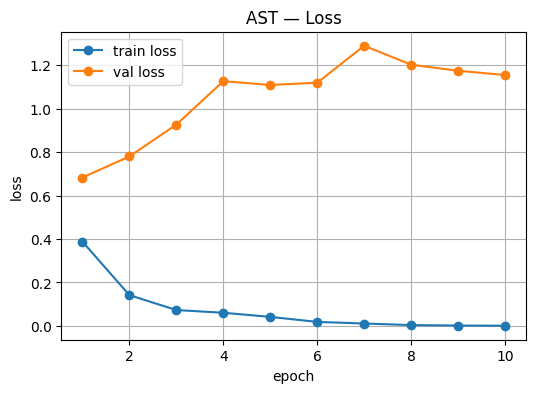

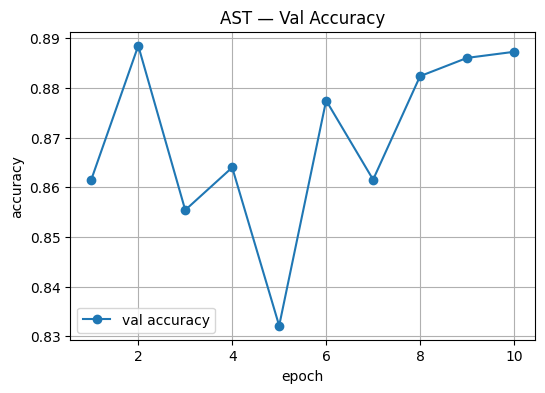

In [19]:
# TODO(1.2): Графики обучения CNN (loss/acc по эпохам)
#  Логгируйте значения из вашего цикла обучения.

# import matplotlib.pyplot as plt

# Пример построения (раскомментируйте и подставьте):
# plt.figure(); plt.plot(history["tr_loss"]); plt.plot(history["va_loss"]); 
# plt.title("CNN — Loss"); plt.legend(["train","valid"]); plt.xlabel("epoch"); plt.show()
# plt.figure(); plt.plot(history["tr_acc"]); plt.plot(history["va_acc"]);
# plt.title("CNN — Accuracy"); plt.legend(["train","valid"]); plt.xlabel("epoch"); plt.show()


import matplotlib.pyplot as plt


# LOSS
plt.figure(figsize=(6,4))
plt.plot(history_ast["epochs"], history_ast["tr_loss"], marker="o", label="train loss")
plt.plot(history_ast["epochs"], history_ast["va_loss"], marker="o", label="val loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("AST — Loss")
plt.legend()
plt.grid(True)
plt.show()

# VAL ACC
plt.figure(figsize=(6,4))
plt.plot(history_ast["epochs"], history_ast["va_acc"], marker="o", label="val accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("AST — Val Accuracy")
plt.legend()
plt.grid(True)
plt.show()


## Задание 2. Эксперимент (выберите один вариант)

**Вариант A:** добавить SpecAugment в обучение CNN.  
**Вариант B:** изменить параметры мел-спектрограмм (например, `N_MELS`, `HOP`, `N_FFT`) и переобучить CNN.

Оформите гипотезу → что меняете → метрики ДО/ПОСЛЕ → краткий вывод.


In [ ]:
# TODO(2.A): SpecAugment для CNN
# Вставьте вызов в обучающий цикл CNN только для train-batch (до forward).
# Подпишите конфигурацию масок.

import numpy as np
import torch

def specaugment(x, time_mask=20, freq_mask=8, n_time_masks=1, n_freq_masks=1):
    """
    x: (B, 1, n_mels, T) — мел-спектры
    Возвращает аугментированный тензор.
    """
    # TODO: реализовать маскирование по времени и по частоте (n_time_masks / n_freq_masks)
    # Подсказка: зануляйте x[:, :, f0:f0+f, :] и x[:, :, :, t0:t0+t]
    return x

# Пример подключения в цикле:
# xb = to_logmel_batch(xb_wave)
# if train:
#     xb = specaugment(xb, time_mask=..., freq_mask=...)
# logits = model(xb)


In [ ]:
# TODO(2.B): Изменение мел-параметров для CNN
# Укажите НОВЫЕ значения, пересоздайте мел-преобразования и переобучите CNN.

# Пример: (замените на свои)
# N_MELS_NEW = 80   # было 64
# HOP_NEW    = 160  # было 25
# N_FFT_NEW  = 1024 # по необходимости

# 1) Пересоздайте MelSpectrogram/AmplitudeToDB с новыми параметрами
# 2) Обновите функцию to_logmel_batch (если параметры зашиты)
# 3) Переобучите CNN и посчитаете метрики (VAL/TEST)


### Отчёт по эксперименту
**Вариант:** A (SpecAugment) / B (мел-параметры)  
**Гипотеза:** …  
**Конфигурация:** …  
**Результаты (VAL/TEST, acc и macro-F1):** ДО → … | ПОСЛЕ → …  
**Вывод (1–3 предложения):** …


## Задание 3. Инференс AST на собственных `.wav`
Загрузите файл(ы), при необходимости ресемплируйте до 16kHz, сделайте топ-K предсказаний AST и прокомментируйте результаты.


In [ ]:
# TODO(3): Инференс AST на своём .wav
# Требуются: processor, ast (обученная модель), SR, id2label

import soundfile as sf

def ast_predict_wav(path, top_k=3):
    # 1) загрузка .wav
    wav, sr = sf.read(path)
    wav = wav.astype(np.float32)

    # 2) ресемплинг при несоответствии частоты
    #TODO

    # 3) препроцессинг
    inputs = processor(wav, sampling_rate=SR, return_tensors="pt", padding=True, truncation=True)
    inputs = {k: v.to(ast.device) for k, v in inputs.items()}

    # 4) инференс
    ast.eval()
    with torch.no_grad():
        logits = ast(**inputs).logits
        probs = torch.softmax(logits, dim=-1).squeeze(0)

    # 5) топ-K
    vals, idx = torch.topk(probs, k=min(top_k, probs.numel()))
    vals, idx = vals.cpu().numpy(), idx.cpu().numpy()
    return [(id2label[int(i)], float(v)) for i, v in zip(idx, vals)]

# Пример:
# ast_predict_wav("my_audio.wav", top_k=5)
